In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import tensorflow as tf
import keras

Using TensorFlow backend.


## DATA

In [2]:
train = pd.read_csv("C:/Users/chand/Downloads/Innoplexus Online Hiring Hackathon Saving lives with AI/train_3PIRKSI/train.csv")
test = pd.read_csv("C:/Users/chand/Downloads/Innoplexus Online Hiring Hackathon Saving lives with AI/test_XEV14AD/test.csv")

In [3]:
#Merging Datasets
train_id = train.id
data = pd.concat([train,test])

C:\Users\chand\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
data = data.fillna(method="ffill")

In [5]:
print("Number of sentences: ", len(data.groupby(['Sent_ID'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  317122
Number of words in the dataset:  257201
Tags: ['I-indications', 'O', 'B-indications']
Number of Labels:  3
What the dataset looks like:


,Doc_ID,Sent_ID,Word,id,tag
0,1,1,Obesity,1,O
1,1,1,in,2,O
2,1,1,Low-,3,O
3,1,1,and,4,O
4,1,1,Middle-Income,5,O
5,1,1,Countries,6,O
6,1,1,:,7,O
7,1,1,Burden,8,O
8,1,1,",",9,O
9,1,1,Drivers,10,O


In [6]:
## Creating POS
from nltk import pos_tag,pos_tag_sents
data_tags = pos_tag(data["Word"])
data["POS"] = [j for i,j in data_tags]

In [7]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("Sent_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Obesity', 'NN', 'O'), ('in', 'IN', 'O'), ('Low-', 'NNP', 'O'), ('and', 'CC', 'O'), ('Middle-Income', 'JJ', 'O'), ('Countries', 'NNS', 'O'), (':', ':', 'O'), ('Burden', 'NNP', 'O'), (',', ',', 'O'), ('Drivers', 'NNP', 'O'), (',', ',', 'O'), ('and', 'CC', 'O'), ('Emerging', 'NNP', 'O'), ('Challenges', 'NNP', 'O'), ('.', '.', 'O')]


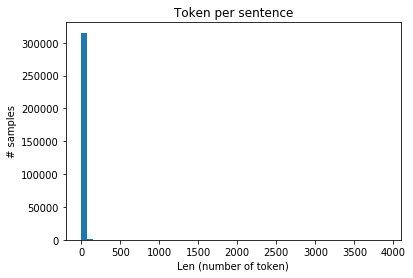

In [8]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Data Preprocessing

In [9]:
BATCH_SIZE = 32
EPOCHS = 20
MAX_LEN = 75
EMBEDDING = 20

In [10]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

In [11]:
print("The word Cancer is identified by the index: {}".format(word2idx["Cancer"]))

The word Cancer is identified by the index: 2708


In [12]:
from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same length
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same length
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

In [13]:
len(sentences)

317122

In [14]:
X.shape

(317122, 75)

In [15]:
## Splitting train and test set
tr = train.groupby("Sent_ID")["Word"].apply(list)
te = test.groupby("Sent_ID")["Word"].apply(list)

In [16]:
print(tr.shape,te.shape)

(191282,) (125840,)


In [17]:
# Creating Final train and test sets
X_train = X[0:191282]
print(X_train.shape)
X_test = X[191282:]
print(X_test.shape)

(191282, 75)
(125840, 75)


In [18]:
len(y)

317122

In [19]:
# Creating Final Predictors y_train
y = y[0:191282]

In [20]:
# from sklearn.model_selection import train_test_split
# X_tr, X_te, y_tr, y_te = train_test_split(X_train, y, test_size=0.1)
# X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

# print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
# print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
# print('After processing, sample:', X[0])
# print('After processing, labels:', y[0])

Raw Sample:  Obesity in Low- and Middle-Income Countries : Burden , Drivers , and Emerging Challenges .
Raw Label:  O O O O O O O O O O O O O O O
After processing, sample: [146497 200224  37148 216988 111398 102853  69751  25443 237363  39128
 237363 216988 176727  57598 189494      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0]
After processing, labels: [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.

## MODEL

We will implement a model similar to Zhiheng Huang’s Bidirectional LSTM-CRF Models for Sequence Tagging.

In [21]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\chand\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\chand\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            5144060   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 4)             228       
Total params: 5,177,738
Trainable params: 5,177,738
Non-trainable params: 0
_________________________________________________________________


## Training and evaluate

In [22]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 154937 samples, validate on 17216 samples
Epoch 1/5
 - 894s - loss: 5.1737 - crf_viterbi_accuracy: 0.9844 - val_loss: 5.0904 - val_crf_viterbi_accuracy: 0.9865
Epoch 2/5
 - 875s - loss: 5.1506 - crf_viterbi_accuracy: 0.9884 - val_loss: 5.0854 - val_crf_viterbi_accuracy: 0.9883
Epoch 3/5
 - 877s - loss: 5.1462 - crf_viterbi_accuracy: 0.9899 - val_loss: 5.0834 - val_crf_viterbi_accuracy: 0.9891
Epoch 4/5
 - 877s - loss: 5.1438 - crf_viterbi_accuracy: 0.9907 - val_loss: 5.0828 - val_crf_viterbi_accuracy: 0.9891
Epoch 5/5
 - 877s - loss: 5.1423 - crf_viterbi_accuracy: 0.9914 - val_loss: 5.0849 - val_crf_viterbi_accuracy: 0.9882


In [23]:
# Eval
pred_cat = model.predict(X_test)
pred = np.argmax(pred_cat, axis=-1)
# y_te_true = np.argmax(y_te, -1)

In [24]:
# from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
# y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

# report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
# print(report)

In [26]:
len(pred_tag)

125840

In [27]:
test.shape

(2994463, 4)

In [33]:
pred_tag.dtype

AttributeError: 'list' object has no attribute 'dtype'

## Generating final Result for submission from pred_tag

In [45]:
#Saving pred_tag 
import pickle
PIK = "pickle.dat"
with open(PIK, "wb") as f:
    pickle.dump(pred_tag, f)

In [48]:
temp = pred_tag.copy()

In [52]:
temp_pr = []
for i in pred_tag:
    for j in range(len(i)):
        if i[j] == "PAD":
            break
        else:
            temp_pr.append(i[j])
            

In [54]:
len(temp_pr)

2969170

In [55]:
len(test)

2994463

In [57]:
temp_test = test.groupby("Sent_ID")["Word"].apply(list)

In [58]:
len(temp_test)

125840

In [59]:
len(pred_tag)

125840

In [63]:
temp_test = pd.DataFrame(temp_test.reset_index())

In [68]:
temp_test = temp_test["Word"]

In [75]:
temp_test[0]

['CCCVA', ',', 'MANOVA', ',', 'my', 'black', 'hen', '.']

In [77]:
temp_pr = []
for i in range(len(temp_test)):
    for j in range(len(temp_test[i])):
        try:
            temp_pr.append(temp[i][j])
        except:
            temp_pr.append("O")

In [79]:
len(temp_pr)

2994463

In [80]:
len(test)

2994463

In [81]:
sample_sub = pd.read_csv("C:/Users/chand/Downloads/Innoplexus Online Hiring Hackathon Saving lives with AI/sample_submission_usrypCc/sample_submission.csv")

In [84]:
sample_sub["tag"] = temp_pr

In [86]:
sample_sub.to_csv("Final_inno.csv",index = False)